## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Load the data [MNIST]

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [3]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

## Define the model

In [20]:
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self):
        super(VAEEncoder, self).__init__()
        # Convolutional layers
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # (batch_size, 1, 28, 28) -> (batch_size, 32, 14, 14)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # (batch_size, 32, 14, 14) -> (batch_size, 64, 7, 7)
            nn.ReLU(),
        )
        # Fully connected layers for mu and log_var
        self.fc_mu = nn.Linear(64*7*7, 20)       # Output mean
        self.fc_log_var = nn.Linear(64*7*7, 20)  # Output log variance
    
    def forward(self, x):
        # Pass through convolutional layers
        x = self.conv_layer(x)
        # Flatten the output for fully connected layers
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 64*7*7)
        # Get the mean (mu) and log variance (log_var)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self):
        super(VAEDecoder, self).__init__()
        # Fully connected layer to upscale from latent space to a feature map
        self.fc_layer = nn.Linear(20, 64*7*7)
        # Deconvolution layers to reconstruct the image
        self.conv_layer = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # (batch_size, 64, 7, 7) -> (batch_size, 32, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 32, 14, 14) -> (batch_size, 1, 28, 28)
            nn.Sigmoid(),  # Output range [0, 1]
        )
    
    def forward(self, x):
        # Pass through fully connected layer to get to the feature map size
        x = self.fc_layer(x)
        # Reshape to (batch_size, 64, 7, 7) for deconvolution layers
        x = x.view(x.size(0), 64, 7, 7)
        # Pass through deconvolution layers to reconstruct the image
        x = self.conv_layer(x)
        return x

# VAE Model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder()
        self.decoder = VAEDecoder()

    def reparameterize(self, mu, log_var):
        """Reparameterization trick to sample from N(mu, var) from N(0,1)"""
        std = torch.exp(0.5 * log_var)  # Standard deviation
        eps = torch.randn_like(std)     # Random noise
        return mu + eps * std           # Reparameterization trick
    
    def forward(self, x):
        # Encode the input into mu and log_var
        mu, log_var = self.encoder(x)
        # Reparameterize to get latent vector
        z = self.reparameterize(mu, log_var)
        # Decode the latent vector back to image
        out_img = self.decoder(z)
        return out_img, mu, log_var


## Define training procedure

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# Hyperparameters
BATCH_SIZE = 4


In [7]:
def loss_function(recon_x, x, mu, log_var):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [22]:
# Model, optimizer
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
vae.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader.dataset):.4f}')


Epoch [1/10], Loss: 144.5944
Epoch [2/10], Loss: 114.1363
Epoch [3/10], Loss: 109.5794
Epoch [4/10], Loss: 107.6238
Epoch [5/10], Loss: 106.3869
Epoch [6/10], Loss: 105.6652
Epoch [7/10], Loss: 105.0381
Epoch [8/10], Loss: 104.5314
Epoch [9/10], Loss: 104.0887
Epoch [10/10], Loss: 103.7688


## Evaluate the results

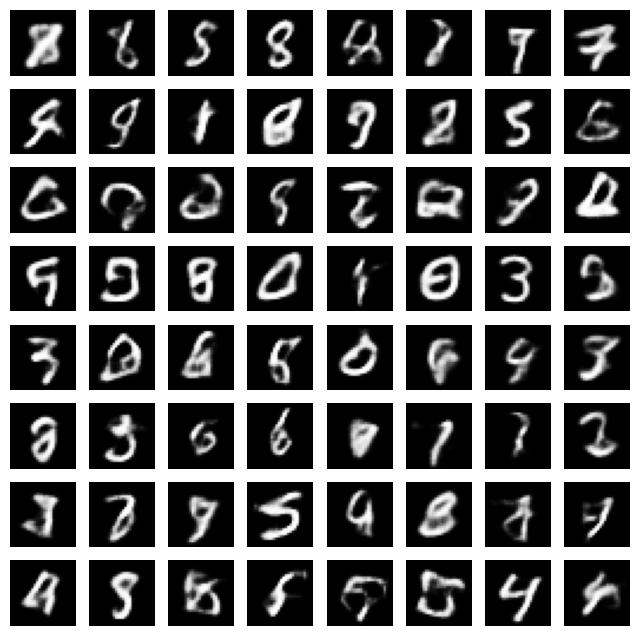

In [23]:
# Sample from latent space and generate images
vae.eval()
with torch.no_grad():
    z = torch.randn(64, 20).to(device)
    sample = vae.decoder(z).cpu()
    sample = sample.view(64, 1, 28, 28)

# Plot the generated images
plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(sample[i][0], cmap='gray')
    plt.axis('off')
plt.show()

In [25]:
z.shape

torch.Size([64, 20])